**Part1**: Visualizations

In [133]:
#Download the dataset
!wget http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz


--2021-02-22 11:44:24--  http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16795330 (16M) [application/x-gzip]
Saving to: ‘booksummaries.tar.gz.4’

booksummaries.tar.g 100%[===================>]  16.02M   670KB/s    in 26s     

2021-02-22 11:44:51 (629 KB/s) - ‘booksummaries.tar.gz.4’ saved [16795330/16795330]



In [134]:
# Unzip the dataset file
!tar -xvf /content/booksummaries.tar.gz

booksummaries/
booksummaries/README
booksummaries/booksummaries.txt


In [135]:
!pip install pyLDAvis

In [136]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
#Import packages
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
data = []

with open("booksummaries/booksummaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            data.append(row)

16559it [00:00, 27995.73it/s]


In [139]:
wiki_article_id = []
freebase_id=[]
book_title = []
author=[]
publish_date=[]
genres = []
plot_summary = []

for i in tqdm(data):
    wiki_article_id.append(i[0])
    freebase_id.append(i[1])
    book_title.append(i[2])
    author.append(i[3])
    publish_date.append(i[4])
    genres.append(i[5])
    plot_summary.append(i[6])

books_complete = pd.DataFrame({'wiki_article_id': wiki_article_id, 'book_title': book_title,'freebase_id':freebase_id,'publish_date':publish_date,'author':author,
                       'genres': genres, 'plot_summary': plot_summary})


books_data= books_complete[['wiki_article_id','book_title','genres', 'plot_summary']]

books_data.head(10)

100%|██████████| 16559/16559 [00:00<00:00, 627028.87it/s]


,wiki_article_id,book_title,genres,plot_summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,Anyone Can Whistle,,The story is set in an imaginary American tow...
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


In [140]:
books_complete.head(10)

,wiki_article_id,book_title,freebase_id,publish_date,author,genres,plot_summary
0,620,Animal Farm,/m/0hhy,1945-08-17,George Orwell,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,/m/0k36,1962,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,/m/0ldx,1947,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,/m/0sww,,David Hume,,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,/m/0wkt,,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,All Quiet on the Western Front,/m/0x5g,1929-01-29,Erich Maria Remarque,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,A Wizard of Earthsea,/m/011zx,1968,Ursula K. Le Guin,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,Anyone Can Whistle,/m/012dq,,Arthur Laurents,,The story is set in an imaginary American tow...
8,4081,Blade Runner 3: Replicant Night,/m/01b4w,1996-10-01,K. W. Jeter,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,Blade Runner 2: The Edge of Human,/m/01b56,1995-10-01,K. W. Jeter,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


In [141]:
books_data.shape

(16559, 4)

In [142]:
books_data.isna().sum()

books_data = books_data.drop(books_data[books_data['genres'] == ''].index)
books_data = books_data.drop(books_data[books_data['plot_summary'] == ''].index)


genres_cleaned = []
for i in books_data['genres']:
    genres_cleaned.append(list(json.loads(i).values()))
books_data['genres_list'] = genres_cleaned


In [143]:
books_data.head(10)

,wiki_article_id,book_title,genres,plot_summary,genres_list
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N..."
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul..."
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]"
6,2890,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f..."
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]"
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]"
15,4386,Book of Job,"{""/m/02mdj1"": ""Religious text""}",The book of Job tells the story of an extreme...,[Religious text]
20,6020,Crash,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...",The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]"


In [144]:

genres_all=sum(genres_cleaned,[])
#print(genres_all)
len(set(genres_all))



227

In [145]:
genres_all = nltk.FreqDist(genres_all) 

# create dataframe
genres_all_df = pd.DataFrame({'Genre': list(genres_all.keys()), 
                              'Count': list(genres_all.values())})

genres_all_df.head(20)

,Genre,Count
0,Roman à clef,29
1,Satire,123
2,Children's literature,2122
3,Speculative fiction,4314
4,Fiction,4747
5,Science Fiction,2870
6,Novella,87
7,Utopian and dystopian fiction,67
8,Existentialism,8
9,Absurdist fiction,29


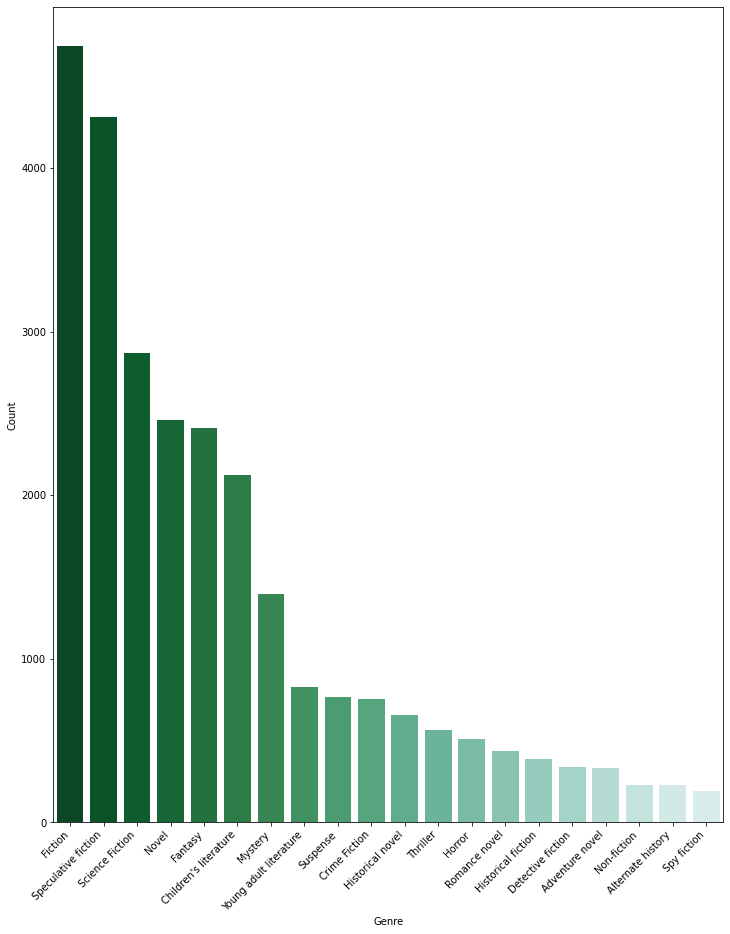

In [146]:
g = genres_all_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(12,15)) 
chart = sns.barplot(data=g, y= "Count", x = "Genre",palette=sns.color_palette("BuGn_r", n_colors=len(g) + 4)) 
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()
plt.show()


In [147]:
books_data.head(10)

,wiki_article_id,book_title,genres,plot_summary,genres_list
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N..."
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul..."
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]"
6,2890,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f..."
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]"
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]"
15,4386,Book of Job,"{""/m/02mdj1"": ""Religious text""}",The book of Job tells the story of an extreme...,[Religious text]
20,6020,Crash,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...",The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]"


Test Pre-processing:


In [148]:
invalid_words = set(stopwords.words("english"))
pattern = "[^a-zA-Z0-9 ]"
r = re.compile(pattern)
ps = PorterStemmer()


def clean_characters(text):
		"""
		Uses regular expressions to sub everything but letters, numbers and spaces
		For improved efficiency we use the classes compiled regular
		a compiled version of this regular expression.
		We also replace newline characters with spaces, as to not join words
		"""
		text = text.replace("\n", " ")
		subbed_text = r.sub("", text)
		return subbed_text


def process_words(words):
		"""
		removes non-informative words like "AND" or "I"
		"""
		return [word for word in words if word not in invalid_words]


def stem_words(words):
		"""
		Stems words, to return words in their original form like
		going to go
		"""
		return [ps.stem(word) for word in words]


def clean_text_withstemming(text):
		"""
		converting to lowercase, 
		performs the process of use regex to clean characters not relevant,
		removing non-important words,
		stemming words, and returning the cleaned text
		"""
		lowercase_text = text.lower()
		cleaned_characters = clean_characters(lowercase_text)
		important_words = process_words(cleaned_characters.split())
		stemmed_words = stem_words(important_words)
		cleaned_text = " ".join(stemmed_words)
		return cleaned_text

def clean_text_nostemming(text):
		"""
		converting to lowercase, 
		performs the process of use regex to clean characters not relevant,
		removing non-important words,
		stemming words, and returning the cleaned text
		"""
		lowercase_text = text.lower()
		cleaned_characters = clean_characters(lowercase_text)
		important_words = process_words(cleaned_characters.split())
		cleaned_text = " ".join(important_words)
		return cleaned_text

In [149]:
books_data['processed_withstem_plot'] = books_data['plot_summary'].apply(lambda x: clean_text_withstemming(x))

In [150]:
books_data['processed_nostem_plot'] = books_data['plot_summary'].apply(lambda x: clean_text_nostemming(x))

In [151]:
books_data.head(10)

,wiki_article_id,book_title,genres,plot_summary,genres_list,processed_withstem_plot,processed_nostem_plot
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",old major old boar manor farm call anim farm m...,old major old boar manor farm calls animals fa...
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...",alex teenag live nearfutur england lead gang n...,alex teenager living nearfuture england leads ...
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",text plagu divid five part town oran thousand ...,text plague divided five parts town oran thous...
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul...",novel posit space around milki way divid conce...,novel posits space around milky way divided co...
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",book tell stori paul bumer german soldier whou...,book tells story paul bumer german soldier who...
6,2890,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f...",ged young boy gont one larger island north arc...,ged young boy gont one larger islands north ar...
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]",live mar deckard act consult movi crew film st...,living mars deckard acting consultant movie cr...
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]",begin sever month event blade runner deckard r...,beginning several months events blade runner d...
15,4386,Book of Job,"{""/m/02mdj1"": ""Religious text""}",The book of Job tells the story of an extreme...,[Religious text],book job tell stori extrem righteou man name j...,book job tells story extremely righteous man n...
20,6020,Crash,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...",The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",stori told eye narrat jame ballard name author...,story told eyes narrator james ballard named a...



**Cluster Analysis**

In [152]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_text = tfidf_vectorizer.fit_transform(books_data['processed_withstem_plot'])

In [153]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(tfidf_text)
books_data['Cluster'] = kmeans.labels_
books_data.head()

,wiki_article_id,book_title,genres,plot_summary,genres_list,processed_withstem_plot,processed_nostem_plot,Cluster
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",old major old boar manor farm call anim farm m...,old major old boar manor farm calls animals fa...,5
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...",alex teenag live nearfutur england lead gang n...,alex teenager living nearfuture england leads ...,2
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",text plagu divid five part town oran thousand ...,text plague divided five parts town oran thous...,1
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul...",novel posit space around milki way divid conce...,novel posits space around milky way divided co...,0
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",book tell stori paul bumer german soldier whou...,book tells story paul bumer german soldier who...,1


In [154]:
for cluster_id in range(10):
    print("Size of cluster %i:" % cluster_id)
    print(len(books_data[books_data.Cluster==cluster_id]))

Size of cluster 0:
933
Size of cluster 1:
2984
Size of cluster 2:
1220
Size of cluster 3:
223
Size of cluster 4:
2194
Size of cluster 5:
3289
Size of cluster 6:
160
Size of cluster 7:
1464
Size of cluster 8:
140
Size of cluster 9:
234



And now, let's obtain the **word clouds**.

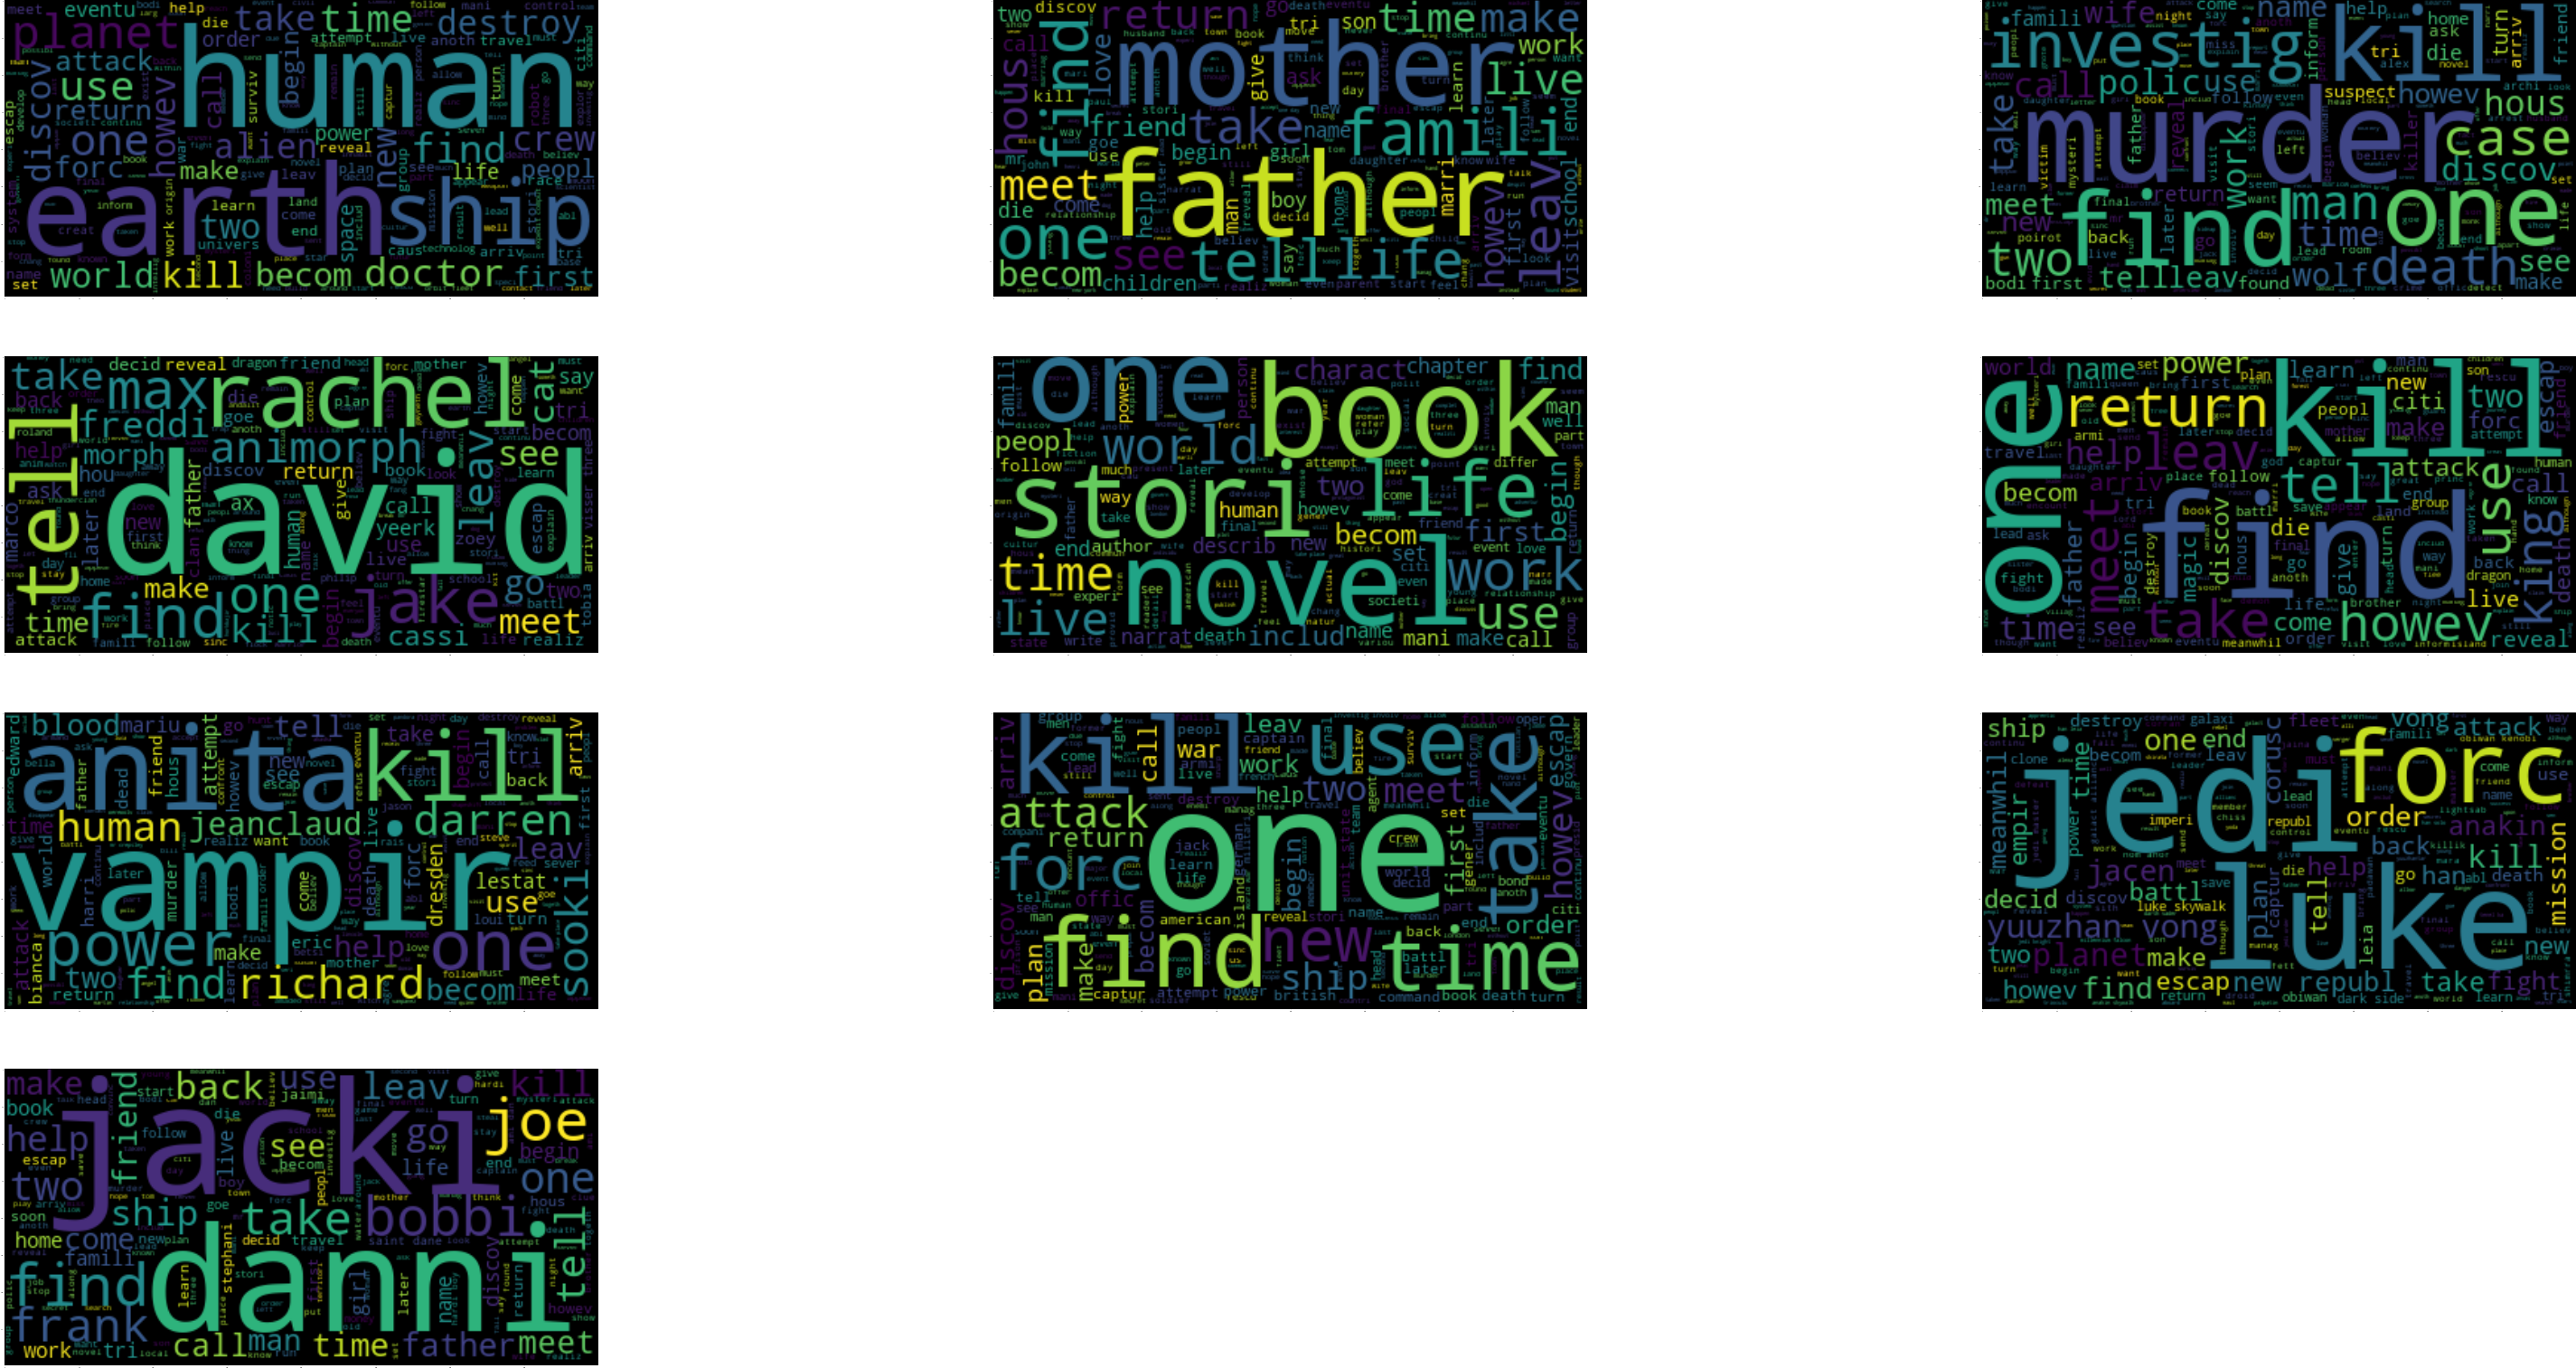

In [155]:
plt.figure(figsize=(400,200), dpi=10)
for cluster_id in range(10):
    plt.subplot(4, 3, cluster_id+1)
    text = ' '.join(books_data[books_data.Cluster==cluster_id].processed_withstem_plot)
    wordcloud = WordCloud(stopwords=STOPWORDS).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')

Due to computational limitation, I could not explore word clouds with more clusters as the above clusters are overlapping.

**Topic Modelling**


In [156]:
count_vectorizer = CountVectorizer(stop_words="english")
count_test = count_vectorizer.fit_transform(books_data['processed_withstem_plot'])

In [157]:
lda_model = LatentDirichletAllocation(n_components=5,
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1 
                                      )

In [158]:
lda_output = lda_model.fit_transform(count_test)

In [159]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, count_test, count_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  28.267997
0       51.163364 -159.968018       2        1  25.702888
1      -73.144554   21.523815       3        1  19.204858
4      -66.410133 -110.606438       4        1  13.702442
3       54.417324   12.443444       5        1  13.121815, topic_info=         Term         Freq        Total Category  logprob  loglift
57363  murder  4413.000000  4413.000000  Default  30.0000  30.0000
56967      mr  5215.000000  5215.000000  Default  29.0000  29.0000
76753    ship  4295.000000  4295.000000  Default  28.0000  28.0000
46000    king  3312.000000  3312.000000  Default  27.0000  27.0000
45887    kill  9698.000000  9698.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
39944   howev   829.832714  6442.041223   Topic5  -6.1072  -0.0185
21789    dead   745.558000  2887.294497   Topic5  -6.2143   0.6770
94061    work   759.798287  6040.745684   Topic5  -6.1954  -0.0423
89673     use   755.946378  7577.483363   Topic5  -6.2005  -0.2741
6905    arriv   751.350044  4948.939119   Topic5  -6.2065   0.1458

[452 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
936        2  0.995829   1950
957        2  0.994085   1960
977        2  0.992302   1970
2570       1  0.108591  abbey
2570       4  0.798599  abbey
...      ...       ...    ...
95199      3  0.031860  young
95199      4  0.123075  young
95199      5  0.135076  young
95942      1  0.012503   zoey
95942      4  0.983570   zoey

[1074 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])


Let's check the topic distribution of some of the documents.

In [160]:
lda_vectors = pd.DataFrame(lda_output)
lda_vectors.columns = ['Topic '+str(i) for i in range(lda_vectors.shape[1])]
lda_vectors.index = ['Document '+str(i) for i in range(lda_vectors.shape[0])]
lda_vectors.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Document 0,0.202016,0.248435,0.458396,0.090748,0.000405
Document 1,0.441534,0.005907,0.163801,0.388376,0.000381
Document 2,0.465544,0.120375,0.135649,0.278074,0.000359
Document 3,0.061557,0.936906,0.000516,0.000510,0.000511
Document 4,0.593909,0.094205,0.310664,0.000610,0.000611


We observe that each document covers several topics, not just one. This is normal when the documents are fairly large, as some of these reviews are. It could also mean that the topics have large overlaps of words, but given the visualisation from piLDAvis, they do not seem to overlap much.

Now, let's print the top words for each topic, to get a sense of what the topics are about:

In [161]:
# Function from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
import numpy as np
def show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.T

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Word 0,novel,ship,tell,murder,king
Word 1,book,human,mr,kill,kill
Word 2,stori,use,leav,investig,magic
Word 3,life,earth,mother,polic,power
Word 4,becom,world,father,death,return
Word 5,time,kill,hous,case,dragon
Word 6,new,forc,day,offic,help
Word 7,famili,time,come,meet,use
Word 8,year,planet,home,return,attack
Word 9,live,attack,friend,jack,becom


**Part 2**: Problem Statement: Multi-Label Classification Problem

We will now one hot encode the target variable, i.e., genre_list by using sklearn’s MultiLabelBinarizer( ). Since there are 227 unique genre tags, there are going to be 227 new target variables. We compare different algorithms and found that a simple 


In [162]:
multilabel_binarizer = MultiLabelBinarizer(sparse_output=True)
#multilabel_binarizer.fit(books_data['genres_list'])

# transform target variable
books_data = books_data.join(
            pd.DataFrame.sparse.from_spmatrix(
                multilabel_binarizer.fit_transform(books_data.pop('genres_list')),
                index=books_data.index,
                columns=multilabel_binarizer.classes_))



In [163]:
books_data.head(10)

,wiki_article_id,book_title,genres,plot_summary,processed_withstem_plot,processed_nostem_plot,Cluster,Absurdist fiction,Adventure,Adventure novel,Albino bias,Alien invasion,Alternate history,American Gothic Fiction,Anthology,Anthropology,Anti-nuclear,Anti-war,Apocalyptic and post-apocalyptic fiction,Autobiographical comics,Autobiographical novel,Autobiography,Bangsian fantasy,Bildungsroman,Biographical novel,Biography,Biopunk,Bit Lit,Black comedy,Boys' school stories,Business,Cabal,Campus novel,Catastrophic literature,Chick lit,Children's literature,Chivalric romance,Collage,Colonial United States romance,Comedy,...,Social sciences,Sociology,Soft science fiction,Space opera,Space western,Speculative fiction,Spirituality,Sports,Spy fiction,Steampunk,Subterranean fiction,Superhero fiction,Supernatural,Suspense,Sword and planet,Sword and sorcery,Techno-thriller,Thriller,Time travel,Tragicomedy,Transgender and transsexual fiction,Transhumanism,Travel,Travel literature,Treatise,True crime,Urban fantasy,Urban fiction,Utopian and dystopian fiction,Utopian fiction,Vampire fiction,War novel,Western,Western fiction,Whodunit,Wuxia,Young adult literature,Youth,Zombie,Zombies in popular culture
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",old major old boar manor farm call anim farm m...,old major old boar manor farm calls animals fa...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",alex teenag live nearfutur england lead gang n...,alex teenager living nearfuture england leads ...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,text plagu divid five part town oran thousand ...,text plague divided five parts town oran thous...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,novel posit space around milki way divid conce...,novel posits space around milky way divided co...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2152,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",book tell stori paul bumer german soldier whou...,book tells story paul bumer german soldier who...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,2890,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",ged young boy gont one larger island north arc...,ged young boy gont one larger islands north ar...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,4081,Blade Runner 3: Replicant Night,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...",live mar deckard act consult movi crew film st...,living mars deckard acting consultant movie cr...,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4082,Blade Runner 2: The Edge of Human,"{""/m/06n90"": ""Science Fiction"", ""/

In [164]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [165]:
books_data.iloc[::,7:234]

,Absurdist fiction,Adventure,Adventure novel,Albino bias,Alien invasion,Alternate history,American Gothic Fiction,Anthology,Anthropology,Anti-nuclear,Anti-war,Apocalyptic and post-apocalyptic fiction,Autobiographical comics,Autobiographical novel,Autobiography,Bangsian fantasy,Bildungsroman,Biographical novel,Biography,Biopunk,Bit Lit,Black comedy,Boys' school stories,Business,Cabal,Campus novel,Catastrophic literature,Chick lit,Children's literature,Chivalric romance,Collage,Colonial United States romance,Comedy,Comedy of manners,Comic book,Comic fantasy,Comic novel,Comic science fiction,Comics,Coming of age,...,Social sciences,Sociology,Soft science fiction,Space opera,Space western,Speculative fiction,Spirituality,Sports,Spy fiction,Steampunk,Subterranean fiction,Superhero fiction,Supernatural,Suspense,Sword and planet,Sword and sorcery,Techno-thriller,Thriller,Time travel,Tragicomedy,Transgender and transsexual fiction,Transhumanism,Travel,Travel literature,Treatise,True crime,Urban fantasy,Urban fiction,Utopian and dystopian fiction,Utopian fiction,Vampire fiction,War novel,Western,Western fiction,Whodunit,Wuxia,Young adult literature,Youth,Zombie,Zombies in popular culture
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(books_data['processed_nostem_plot'], books_data.iloc[::,7:234], test_size=0.33, random_state=9)

In [167]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

We will have to build a model for every one-hot encoded target variable. Since we have 227 target variables, we will have to fit 227 different models with the same set of predictors (TF-IDF features).

Since 227 models can take a considerable amount of time on a modest system ..., I will build a **Logistic Regression model** as it is quick to train on limited computational power

In [168]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [169]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [170]:

# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [171]:

y_pred[200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [172]:
multilabel_binarizer.inverse_transform(y_pred)[200]

('Fantasy', 'Speculative fiction')

In [173]:
# evaluate performance
f1_score(yval, y_pred, average="micro")


0.350591368371583

**Conclusion**:  We used simple logistic regression and got an accouracy of 35% 

**Future Work** : Using Transfer learning would be beneficial on this dataset. Fine-tuning BERT for classification from pytorch huggingface is one pathway.